# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

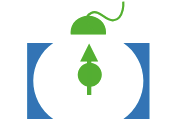

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [ ]:
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation

initial_params = {
    "POVM": [0.1, -3 * jnp.pi / 2],
}
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=rho_cav,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=initial_params,
    num_time_steps=5,
    mode="lookup",
    goal="purity",
    optimizer="adam",
    max_iter=1000,
    convergence_threshold=1e-20,
    learning_rate=0.01,
    type="density",
    batch_size=10,
)

Iteration 0, Loss: 0.751362
Iteration 10, Loss: 0.970985
Iteration 20, Loss: 0.953139
Iteration 30, Loss: 0.976858
Iteration 40, Loss: 0.771187
Iteration 50, Loss: 1.423624
Iteration 60, Loss: 0.782324
Iteration 70, Loss: 1.086410
Iteration 80, Loss: 1.221447
Iteration 90, Loss: 0.838096


In [6]:
result

FgResult(optimized_trainable_parameters={'initial_params': [Array([ 0.22952639, -4.71366611], dtype=float64)], 'lookup_table': [[Array([-0.4383442 , -1.56423498], dtype=float64), Array([-2.38274381, -0.2967422 ], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Arr

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_state)

[[[ 9.07907690e-01+0.j -2.08289172e-01+0.j -9.48070463e-02+0.j ...
   -8.20367531e-03+0.j -7.29701056e-03+0.j -7.31058633e-03+0.j]
  [-2.08289172e-01+0.j  6.02158904e-02+0.j  1.88128644e-02+0.j ...
    1.53624050e-03+0.j  1.44187786e-03+0.j  1.38593640e-03+0.j]
  [-9.48070463e-02+0.j  1.88128644e-02+0.j  1.07261350e-02+0.j ...
    8.97445099e-04+0.j  7.95786879e-04+0.j  7.98479477e-04+0.j]
  ...
  [-8.20367531e-03+0.j  1.53624050e-03+0.j  8.97445099e-04+0.j ...
    1.35971522e-04+0.j  9.53790413e-05+0.j  1.15233989e-04+0.j]
  [-7.29701056e-03+0.j  1.44187786e-03+0.j  7.95786879e-04+0.j ...
    9.53790413e-05+0.j  7.35663707e-05+0.j  8.22544365e-05+0.j]
  [-7.31058633e-03+0.j  1.38593640e-03+0.j  7.98479477e-04+0.j ...
    1.15233989e-04+0.j  8.22544365e-05+0.j  9.92854530e-05+0.j]]

 [[ 1.07074446e-01+0.j -1.31359572e-01+0.j  7.01345254e-03+0.j ...
    1.55560750e-04+0.j  1.39409757e-03+0.j  5.01077219e-04+0.j]
  [-1.31359572e-01+0.j  7.73486793e-01+0.j -9.15388695e-02+0.j ...
   -1.74

In [10]:
result.optimized_trainable_parameters['lookup_table']

[[Array([-0.4383442 , -1.56423498], dtype=float64),
  Array([-2.38274381, -0.2967422 ], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0.,

In [11]:
# 0.8119213228423314
print(result.final_purity)

0.6784122082853643


In [12]:
from feedback_grape.utils.purity import purity

print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.20000208604889932
Purity of state 0: 0.9573530836476466
Purity of state 1: 0.7542503813893793
Purity of state 2: 0.5231118582412756
Purity of state 3: 0.3938009958919692
Purity of state 4: 0.4277724006501076
Purity of state 5: 0.575384251570743
Purity of state 6: 0.7941739211684848
Purity of state 7: 0.9573530836476466
Purity of state 8: 0.6466717252570104
Purity of state 9: 0.7542503813893793


In [ ]:
result.returned_params

[[Array([[ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00],
         [ 6.40519374e-16, -4.60766923e+00]], dtype=float64)],
 [Array([[1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618],
         [1.54823643, 0.20729618]], dtype=float64)],
 [Array([[0.77614797, 0.09302298],
         [0.77614797, 0.09302298],
         [0.47469224, 1.27819312],
         [0.47469224, 1.27819312],
         [0.47469224, 1.

In [ ]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [13]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))

rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
params for time step 0: [ 0.22952639 -4.71366611]
purity of rho after time step 0 0.3046775213232879
params for time step 1: [-0.4383442  -1.56423498]
purity of rho after time step 1 0.2530277067705835
params for time step 2: [-0.69531792 -1.76807957]
purity of rho after time step 2 0.36712786945083886
params for time step 3: [-0.84848156 -1.8743525 ]
purity of rho after time step 3 0.5420177700717478
params for time step 4: [-0.86060473 -1.81117816]
purity of rho after time step 4 0.3385602961728816


In [ ]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.0973540364721641
0.9026459635278362


### Check stash for replacement of dict implementation

In [ ]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 2.41667672e-04+0.j  1.47070190e-02+0.j -7.99698085e-04+0.j
  -8.22787906e-05+0.j -1.21488623e-04+0.j  2.94714182e-05+0.j
  -1.45746463e-05+0.j  8.00629318e-05+0.j -6.84589934e-05+0.j
  -4.61484581e-05+0.j -3.07262921e-05+0.j  6.10544740e-05+0.j
   2.11594187e-05+0.j -3.31968701e-05+0.j -5.72059348e-06+0.j
  -7.59056601e-05+0.j -1.58555647e-05+0.j -2.29163407e-05+0.j
   5.98004713e-06+0.j -1.86580311e-05+0.j  3.78791749e-07+0.j
   7.27903339e-06+0.j -2.81030651e-05+0.j -2.86973370e-05+0.j
   1.35340983e-06+0.j  2.28697218e-06+0.j -1.42865201e-05+0.j
  -3.97499227e-05+0.j -3.48756568e-05+0.j -3.35317781e-06+0.j]
 [ 1.47070190e-02+0.j  8.98504143e-01+0.j -4.95543764e-02+0.j
  -6.06696209e-03+0.j -8.33771793e-03+0.j -6.65324250e-03+0.j
  -8.58291714e-04+0.j  3.00192534e-04+0.j -4.02948085e-03+0.j
  -4.38855633e-03+0.j -1.81686106e-03+0.j  3.58253431e-03+0.j
   1.29139028e-03+0.j -1.99403198e-03+0.j -3.80646757e-04+0.j
  -5.01194586e-03+0.j -9

In [ ]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 9.96964987e-01+0.j -2.75876693e-02+0.j -9.18934281e-03+0.j ...
   -7.40919924e-04+0.j -7.35158190e-05+0.j -1.74060566e-03+0.j]
  [-2.75876693e-02+0.j  8.12671230e-04+0.j  2.51300333e-04+0.j ...
    1.92764243e-05+0.j  7.67811869e-07+0.j  5.43415314e-05+0.j]
  [-9.18934281e-03+0.j  2.51300333e-04+0.j  1.04562009e-04+0.j ...
    6.76069958e-06+0.j  1.14161791e-06+0.j  1.20572941e-05+0.j]
  ...
  [-7.40919924e-04+0.j  1.92764243e-05+0.j  6.76069958e-06+0.j ...
    7.47463169e-07+0.j  1.52436730e-07+0.j  9.18133731e-07+0.j]
  [-7.35158190e-05+0.j  7.67811869e-07+0.j  1.14161791e-06+0.j ...
    1.52436730e-07+0.j  1.83056654e-07+0.j -3.22111069e-07+0.j]
  [-1.74060566e-03+0.j  5.43415314e-05+0.j  1.20572941e-05+0.j ...
    9.18133731e-07+0.j -3.22111069e-07+0.j  7.08780374e-06+0.j]]

 [[ 3.13318455e-02+0.j  1.71732518e-02+0.j  1.49274788e-01+0.j ...
   -5.44131404e-03+0.j -6.61081695e-03+0.j -6.24302464e-03+0.j]
  [ 1.71732518e-02+0.j  1.23541561e-02+0.j  1.0115

In [ ]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [ ]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [ ]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [ ]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [ ]:
batch_size = 2

In [ ]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [ ]:
rho_final_batched.shape

(2, 30, 30)

In [ ]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [ ]:
rng_keys[0].shape

(2,)

In [ ]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]
